# Pre-computation (new)

Proceeds in two steps:
1. Statistical step: From the Lorenz curve, derivive a smooth density function (we use quintic spline approximation to the Lorenz curve).
2. Approximation step: To the smooth density, fit a ~100 point adaptive linear spline. Repeat checks.
    
Must
- Non-negative
- Integrates to 1
    
Should
- Not have too many oscillations
- Reproduces statistics e.g. Gini, HC, etc.

In [281]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
from utils import *
from models import *

In [282]:
d = dict()
lnd = dict()
for fn in glob.glob('../jsoncache/*.json'):
    #print(fn)
    try:
        survey = IncomeDistribution(fn, 1e-8)
        lnd_survey = LognormalIncomeDistribution(fn)
        if survey.cc3 not in d:
            d[survey.cc3] = dict()
            lnd[survey.cc3] = dict()
        d[survey.cc3][survey.year] = survey
        lnd[survey.cc3][survey.year] = lnd_survey
    except (ValueError, KeyError) as e:
        print(fn, e)
    except (Exception) as e:
        print(fn, e)


/usr/local/lib/python3.5/site-packages/scipy/interpolate/fitpack2.py:222: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


../jsoncache/BLR_3_1988.json (m>k) failed for hidden m: fpcurf0:m=5
../jsoncache/CHN_5_2008_0.json math domain error
../jsoncache/CHN_5_2012_0.json math domain error
../jsoncache/EST_3_1988.json (m>k) failed for hidden m: fpcurf0:m=5
../jsoncache/GIN_3_1991.json (m>k) failed for hidden m: fpcurf0:m=5
../jsoncache/GNB_3_1991.json 'Gini'
../jsoncache/GTM_3_1998.json 'Gini'
../jsoncache/GUY_3_1992.5.json 'Gini'
../jsoncache/IDN_5_2013_0.json math domain error
../jsoncache/IND_5_2011.5_0.json math domain error
../jsoncache/KAZ_3_1988.json (m>k) failed for hidden m: fpcurf0:m=5
../jsoncache/KGZ_3_1988.json (m>k) failed for hidden m: fpcurf0:m=5
../jsoncache/LTU_3_1988.json (m>k) failed for hidden m: fpcurf0:m=5
../jsoncache/LVA_3_1988.json (m>k) failed for hidden m: fpcurf0:m=5
../jsoncache/MDA_3_1988.json (m>k) failed for hidden m: fpcurf0:m=5
../jsoncache/NAM_3_1993.79.json 'Gini'
../jsoncache/RUS_3_1988.json (m>k) failed for hidden m: fpcurf0:m=5
../jsoncache/SLE_3_1989.75.json 'Gini'
..

In [285]:
country = "MOZ"
for y in d[country]:
    print(y, d[country][y].sample_N)

2008 10832
2002 8697
1996 8250


In [ ]:
#TODO
# - deal with edge case distributions without a peak structure
# - penalize two peaks close together

1e-05 2 0
3.51119173422e-06 2 0
1.23284673944e-06 2 0
4.32876128108e-07 2 0
1.51991108295e-07 4 0
5.33669923121e-08 2 0


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater


1.87381742286e-08 8 0
6.57933224658e-09 20 0
2.31012970008e-09 32 0
8.1113083079e-10 40 0
2.84803586844e-10 49 0
1e-10 58 0


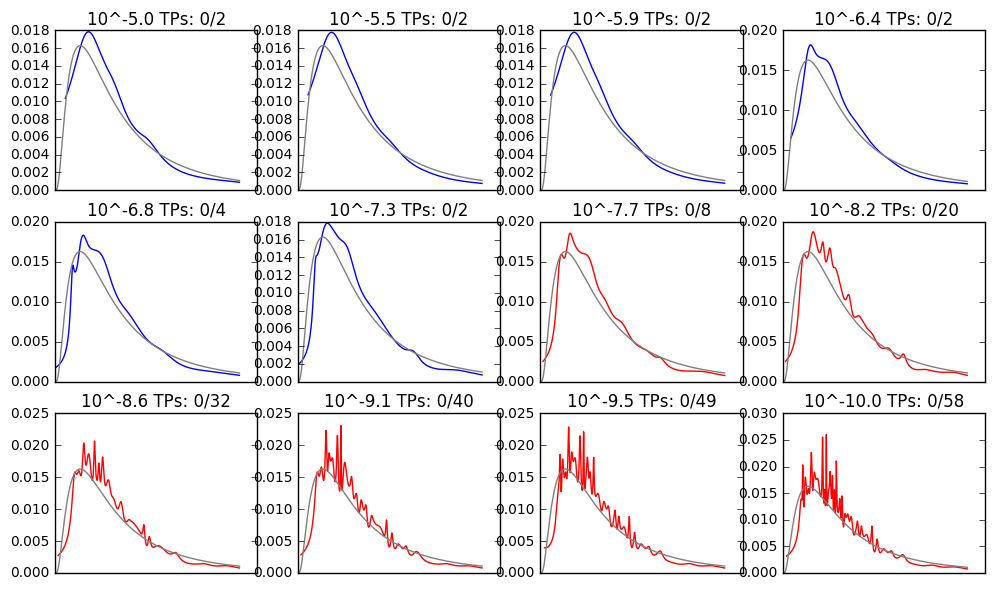

In [286]:
##########################################
plt.rcParams["figure.figsize"] = (12,7)
fig, ax = plt.subplots(3, 4)
ax = ax.flatten()
##########################################

year = 2008
thed = d[country][year]

yrange = np.linspace(0, thed.quantile(0.95), 1000)

for i, (exponent, s) in enumerate((x, 10**x) for x in np.linspace(-5,-10,12)):
    try:
        thed.init_fit(s)
        thep = thed.pdf(yrange)

        turning_points = np.diff(np.sign(np.diff(thep)))
        turning_points = np.logical_and(np.isfinite(turning_points), turning_points != 0)
        turning_points = np.pad(turning_points, (1,1), 'constant', constant_values=(True,False))

        spike_heights = np.diff(thep[turning_points])
        spike_widths = np.diff(yrange[turning_points])
        bad_spikes = np.logical_and(spike_heights / spike_heights[0] > 0.05, spike_heights/spike_widths > 1 * spike_heights[0]/spike_widths[0])[1:]
        bad_spike_count = np.sum(bad_spikes)

        count_turning_points = np.sum(turning_points)
        print(s, count_turning_points, bad_spike_count)
        if bad_spike_count > 0 or count_turning_points > 7:
            thecolor = "r"
        else:
            thecolor = "b"
        ax[i].plot(yrange, thep,color=thecolor)
        ax[i].plot(yrange, lnd[country][year].pdf(yrange), color="grey")
        ax[i].set_title("10^{} TPs: {}/{}".format(round(exponent,1), bad_spike_count, count_turning_points))
        ax[i].get_xaxis().set_visible(False)
    except IndexError:
        pass

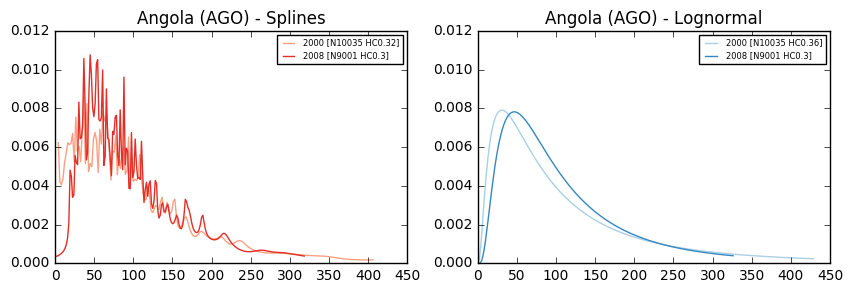

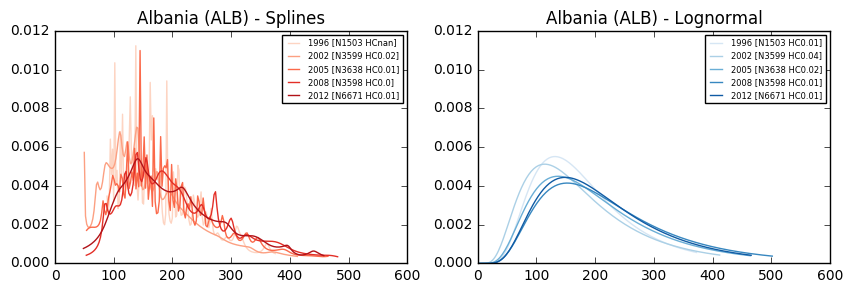

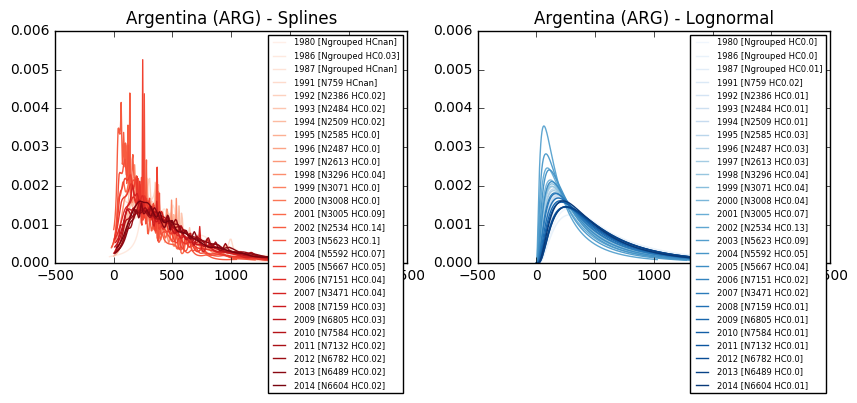

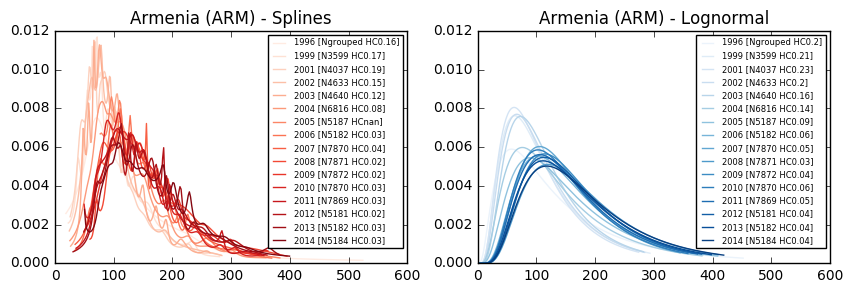

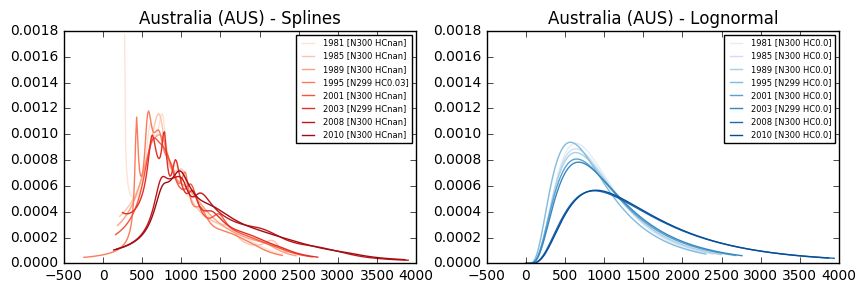

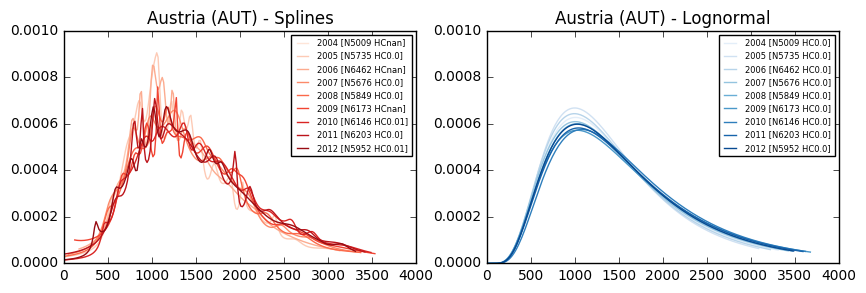

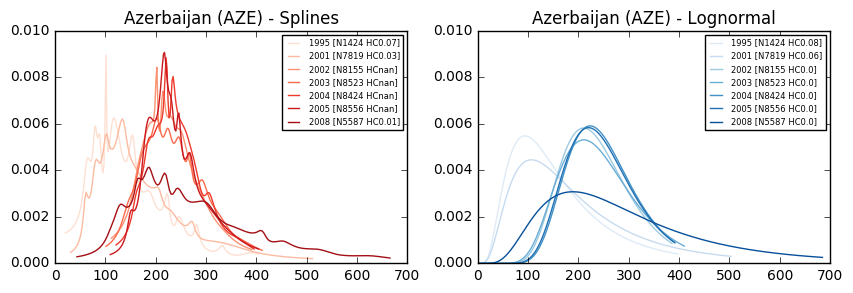

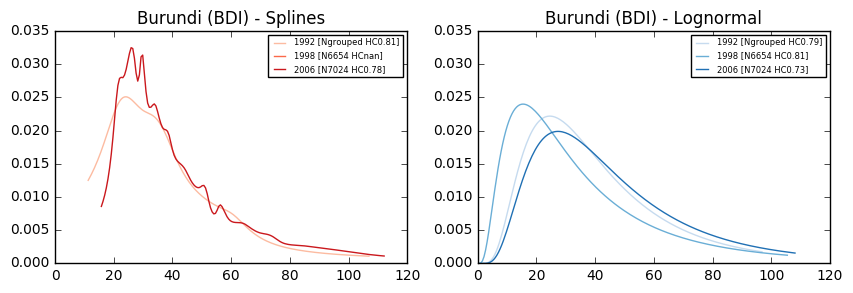

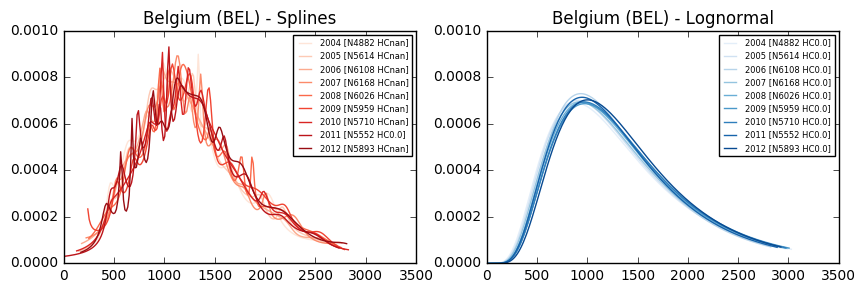

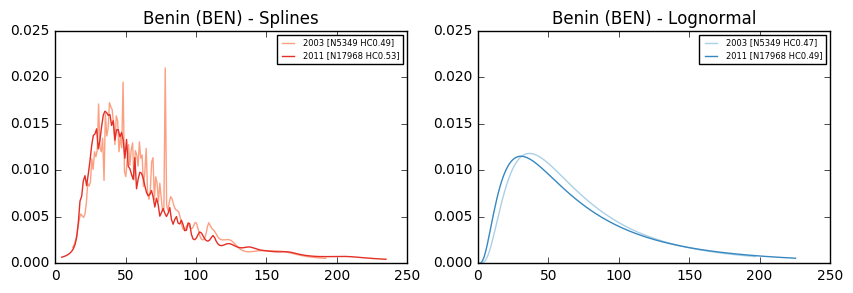

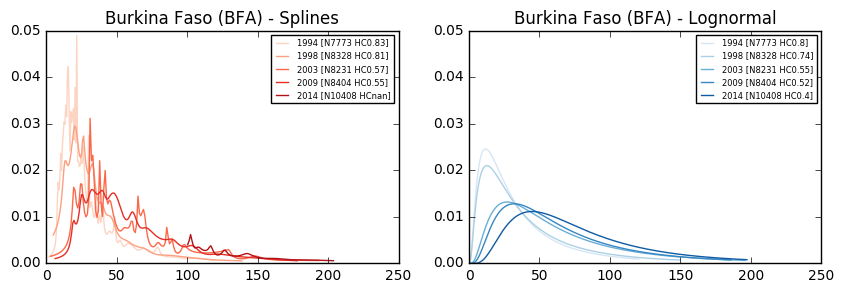

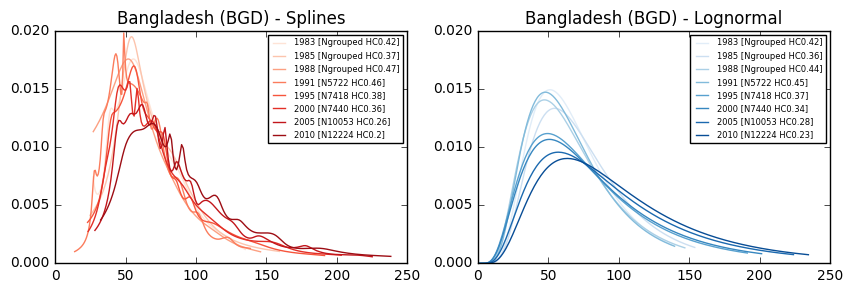

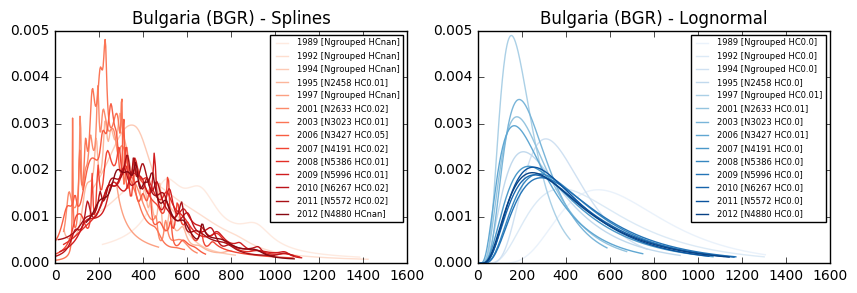

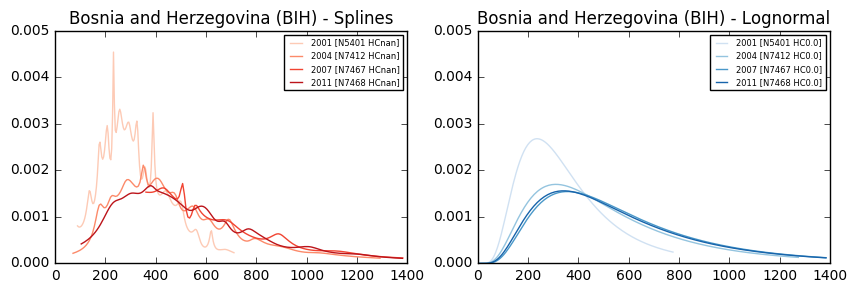

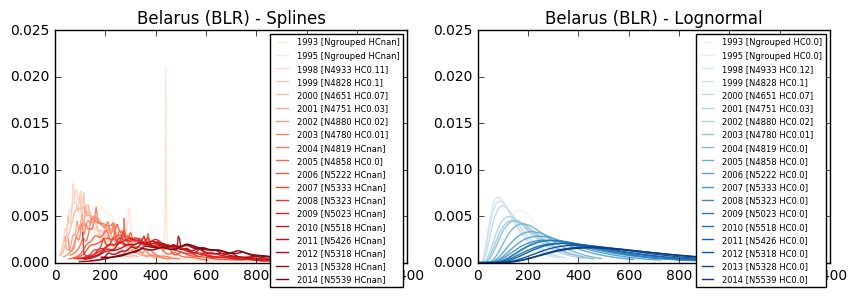

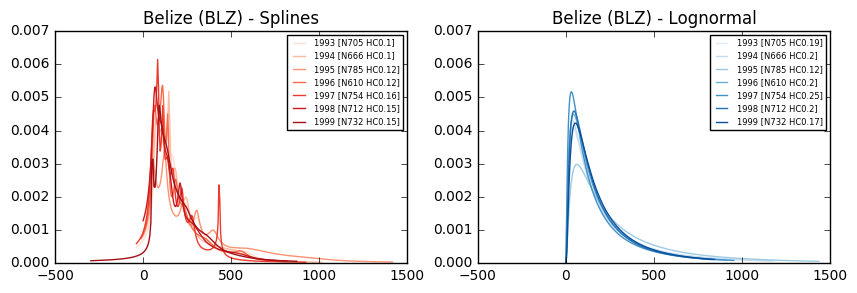

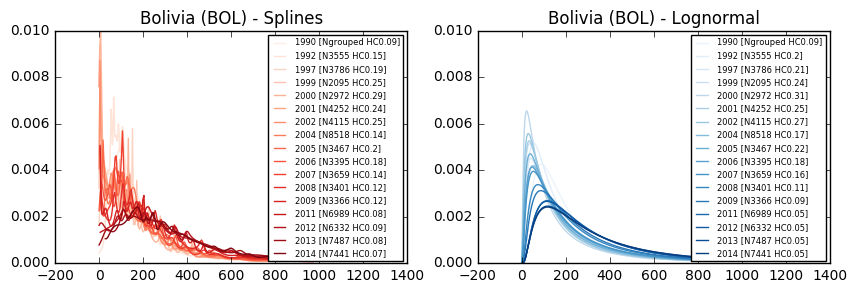

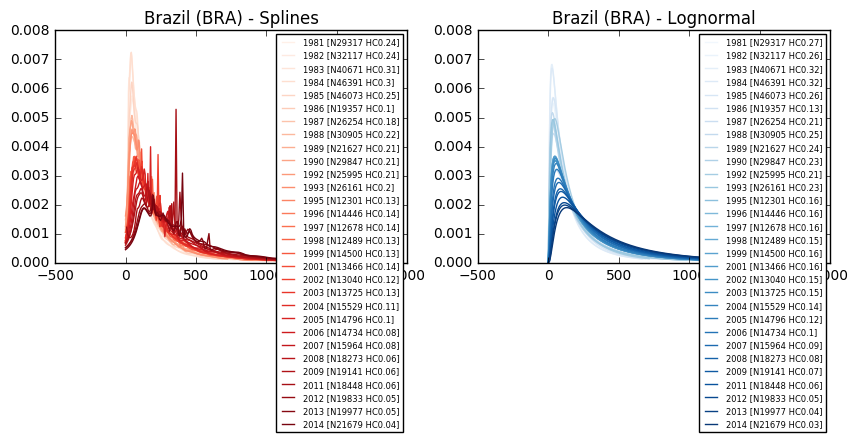

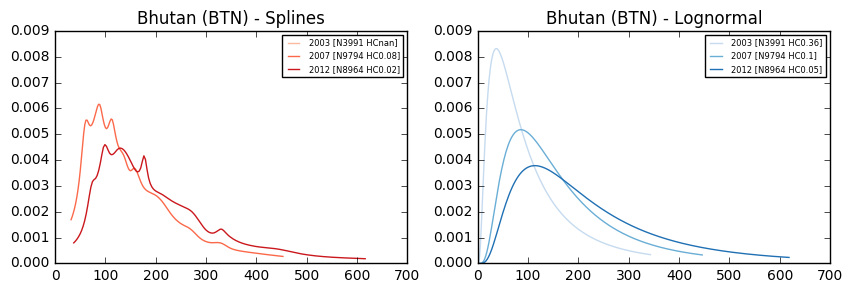

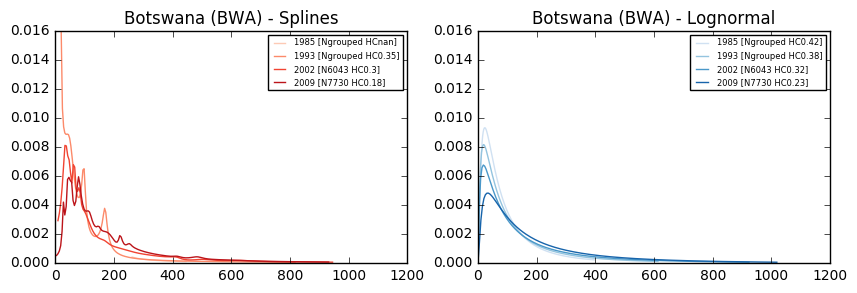

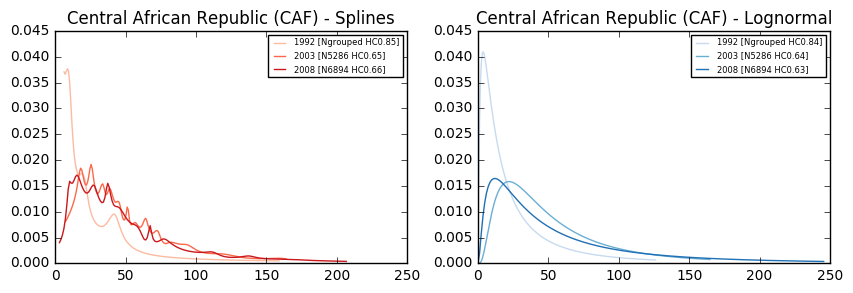

KeyboardInterrupt: 

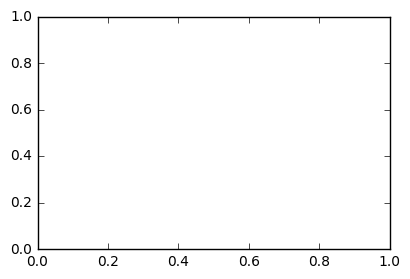

In [249]:
##########################################
plt.rcParams["figure.figsize"] = (10,3)
##########################################

plot_no = 0
cmap = plt.cm.get_cmap('Reds')
cmap_lnd = plt.cm.get_cmap('Blues')
iso3cs = sorted(d)
for iso3c in iso3cs:
    #fig, ax = plt.subplots(1, 2)
    years = sorted(d[iso3c])
    ax1 = plt.subplot(121)
    for i, year in enumerate(years):
        grid = d[iso3c][year].grid()
        plt.plot(grid.y, grid.pdf, label="{} [N{} HC{}]".format(year, d[iso3c][year].sample_N, np.round(d[iso3c][year].HC(),2)), color=cmap((i+1)/(len(years)+1)))
    plt.title("{} ({}) - Splines".format(d[iso3c][year].country, iso3c))
    plt.legend(loc='upper right', prop={'size':6})

    ax2 = plt.subplot(122, sharex = ax1, sharey = ax1)
    for i, year in enumerate(years):
        grid_lnd = lnd[iso3c][year].grid()
        plt.plot(grid_lnd.y, grid_lnd.pdf, label="{} [N{} HC{}]".format(year, lnd[iso3c][year].sample_N, np.round(lnd[iso3c][year].HC(),2)), color=cmap_lnd((i+1)/(len(years)+1)))
    plt.title("{} ({}) - Lognormal".format(lnd[iso3c][year].country, iso3c))
    plt.legend(loc='upper right', prop={'size':6})

    plt.show()


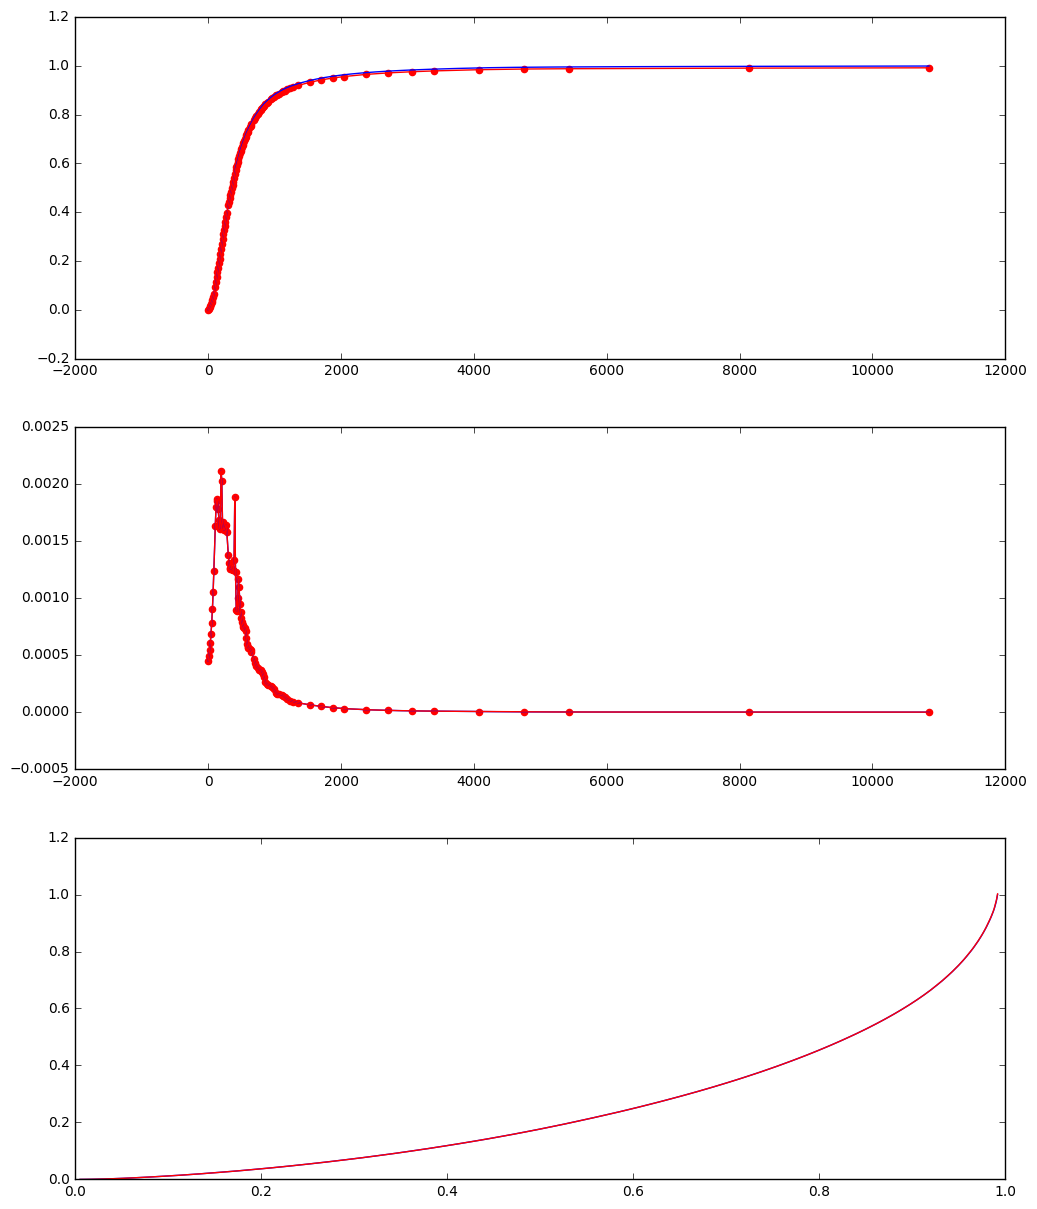

In [30]:
bra = d['BRA'][2014]
x = np.linspace(bra.quantile(0)+1, bra.quantile(0.999), 1000)
Fx = bra.cdf(x)
fx = bra.pdf(x)
dfx = np.pad(fx[1:]-fx[:-1],[1,0],'constant',constant_values=float("NaN"))
ddfx = np.pad(dfx[1:]-dfx[:-1],[0,1],'constant',constant_values=float("NaN"))
abs_ddfx = np.abs(ddfx)

##########################################
plt.rcParams["figure.figsize"] = (12,15)
fig, ax = plt.subplots(3, 1)
##########################################
K = 100

smoothing = 1
direction = None
adjustment = 2
for iterations in range(100): # maximum iterations
    spline_fx = scipy.interpolate.UnivariateSpline(x, fx, k=1, s=smoothing)
    knots = spline_fx.get_knots()
    #print(len(knots),smoothing)
    if (len(knots)==K):
        break
    elif (len(knots) > K):
#        if (direction == -1):
#            adjustment /= 2
        smoothing *= adjustment
        direction = 1
    elif (len(knots) < K):
#        if (direction == 1):
#            adjustment /= 2
        smoothing /= adjustment
        direction = -1

ax[0].plot(x,Fx)
ax[0].plot(knots,spline_fx.antiderivative()(knots),color="r")
ax[0].scatter(knots,spline_fx.antiderivative()(knots),color="r")

ax[1].plot(x,fx)
ax[1].plot(x,spline_fx(x),color="r")
ax[1].scatter(knots,spline_fx(knots),color="r")

mean = sum(((x[1:] - x[:-1])*(x[1:] + x[:-1])/2*spline_fx((x[1:] + x[:-1])/2)))
ax[2].plot(spline_fx.antiderivative()(x[1:]), np.cumsum(((x[1:] - x[:-1])*(x[1:] + x[:-1])/2*spline_fx((x[1:] + x[:-1])/2)))/mean)
ax[2].plot(spline_fx.antiderivative()(knots[1:]), np.cumsum(((knots[1:] - knots[:-1])*(knots[1:] + knots[:-1])/2*spline_fx((knots[1:] + knots[:-1])/2)))/mean, "r")

#ax[2].plot(spline_fx.antiderivative()(knots), np.cumsum(knots)/mean,"r")

In [ ]:
print("y = [{}];".format(",".join(str(k) for k in knots)))
print("fy = [{}];".format(",".join(str(k) for k in spline_fx(knots))))
print()
print(d['BRA'][2014].mean_ppp_month, d['BRA'][2014].Gini)

In [ ]:
region_cols = {'EAS': 'red', 'ECS': 'blue', 'LCN': 'green', 'MEA': 'yellow', 'NAC': 'blue', 'SAS': 'orange', 'SSF': 'pink'}
region_sort = {'EAS': 7, 'ECS': 2, 'LCN': 4, 'MEA': 5, 'NAC': 1, 'SAS': 6, 'SSF': 3}
grid = np.arange(0,300,0.2)

stacks = sorted(latest_country_years.items(), key = lambda x: (region_sort[d[x[0]][x[1]].region_wb], d[x[0]][x[1]].population))
bigdf = np.row_stack([np.nan_to_num(d[cc3][year].population*d[cc3][year].pdf_smooth_semilog(grid)) for (cc3, year) in stacks])

ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
plt.xlim(0.1,300)
plt.stackplot(grid,bigdf,colors=[region_cols[d[cc3][year].region_wb] for (cc3, year) in stacks],edgecolor='none')
plt.axvline(1.90)
plt.axvline(20)
plt.show()

In [ ]:
grid

# Issues

- It seems like BRA 2010 is not a well-formed Lorenz curve, around 57,58 it is non-convex
- Some distributions are just noisy - e.g. GBR 2010 - these are messy to plot as distributions, better to plot as histograms?

## When plotting a density on a semilog (x) chart, need to rescale y to preserve integral

The maths is relatively straightforward. Ordinarily we are plotting $f(x)$ against $x$, but now we are plotting against $y = log_{10}(x)$. Then $x = 10^y$ and so by a change of variables, we are plotting $f(10^y)$ against $y$ (but labelled with $x$). Then we can use change of variables to write the integral as

$$\int_a^b f(x)\,dx = \int_{\log_{10}(a)}^{\log_{10}(b)} (\log 10) 10^y f(10^y)\,dy = K \int_{\log_{10}(a)}^{\log_{10}(b)} x f(x)\,dy $$

so that we need to rescale the y-values by x in order to preserve areas on a semilog chart. With this transformation, the appearance of shapes (e.g. symmetry) is not preserved and the y-axis becomes hard to interpret.

In [ ]:
%matplotlib notebook
from scipy.stats import uniform

x_axis = np.arange(0, 20, 0.01)
y1 = uniform.pdf(x_axis,1,1)
y2 = uniform.pdf(x_axis,10,1)
plt.plot(x_axis, y1)
plt.plot(x_axis, y2)


In [ ]:
plt.semilogx(x_axis, (x_axis)*y1)
plt.semilogx(x_axis, (x_axis)*y2)